## Векторные представления слов

Векторные представления слов (или embeddings) - это наборы чисел, которые должны как-то отражать смысл/значение слов. Формально значение определить очень сложно, поэтому в NLP используются очень упрощенные и утилитарные подходы к пониманию значения. Например, можно считать, что векторные представления хорошо передают смысл слов, если близость (по какой-то выбранной метрике) между похожими словами большая, а между противоположными - большая. Другой пример - с помощью векторных представлений получается хорошо решить задачу, которая требует понимания смысла (т.е. почти любую NLP задачу), значит эти векторные представления хорошо кодируют смысл.

Единственная окололингвистическая теоретическая часть, о которой стоит сказать это дистрибутивная гипотеза. Она состоит в том, что лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения. Обычно в научных статьях цитируют John Firth (Ферс) - '*You shall know a word by the company it keeps*' (Firth, J. R. 1957:11)
Также в "Филосовских исследованиях" Витгенштейна есть такое -  *“For a large class of cases—though not for all—in which we employ the word ‘meaning’ it can be defined thus: **the meaning of a word is its use in the language.**”* (1951)

Саму область иногда называют дистрибутивная семантика.

Давайте посмотрим, как можно строить векторные представления слов.

In [36]:
#!pip install matplotlib pandas

In [37]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [38]:
# в нашем корпусе 20к текстов
wiki = open('/content/wiki_data.txt').read().split('\n')

In [39]:
len(wiki)

20003

Напишем простую функцию, которая для заданного слова найдет ближайшие ему слова в матрице

In [40]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

## Word2Vec

Word2Vec был создан в 2013 году в Google командой под руководством Tomas Mikolov.

Он был описан в двух статьях:
1. https://arxiv.org/abs/1301.3781   
2. https://aclanthology.org/N13-1090/

С word2vec началась transfer learning и self supervised революция в NLP. Вместо обучения моделей с нуля под каждую конкретную задачу люди стали предобучать общие модели на сыром тексте и затем дообучать их под нужные задачи, используя размеченные данные.  У такого подхода сразу несколько преимуществ:
1. он просто лучше работает, так как помимо самих размеченных данных, модель косвенно использует большое количество знаний из предобучающего корпуса;
2. размеченных данных нужно сильно меньше (для достижения качества сопостовимого с моделью обученной с нуля), так как предобученной модели не нужно выучивать базовое понимание языка, она сразу может фокусироваться на специфичных для задачи паттернах;
3. одну предобученную модель можно переиспользовать в разных задачах (часто такие модели создаются крупными компаниями/лабами с огромными вычислительными ресурсами, а затем выкладываются в открытый доступ) .

Также важным достоинством самого word2vec была его эффективность (и по скорости и по потреблению ресурсов), что с одной строны позволило большим компаниям обучить модели на огромных корпусах, а с другой дало возможность отдельным исследователям строить качественные специфичные модели (например, на корпусе научных статей по математике), используя небольшие сервера или вообще личные компьютеры.

Сейчас word2vec уже конечно устарел (но он может быть хорошим бейзлайном), транформерные модели лучше. Но через word2vec удобно начать переходить к нейронным сетям (так как это на самом деле однойслойная нейронка). Поэтому мы попробуем воспроизвести базовые составляющие алгоритма на tensorflow, параллельно разобрав и основы deep learning. В Word2Vec очень много деталей и оптимизаций, которые мы опустим, при решении конкретной задачи лучше использовать готовую реализацию (ниже мы это сделаем через gensim).

### word2vec в tensorflow

Для начала нам нужно построить словарь.

Предобработка нам не так важна. Главное - получить из текстов токены.

In [41]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [42]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

443к слов - это многовато

In [43]:
len(vocab)

443922

Возьмем только те, что встретились больше 30 раз.

In [44]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [45]:
len(filtered_vocab)

17016

~17к - уже нормальная цифра

Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре).

Создадим для этого специальный словарь с индексами. В этот словарь нам нужно положить дополнительный токен - PAD (чуть ниже станет понятнее)

In [46]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [47]:
id2word = {i:word for word, i in word2id.items()}

Заменяем слова на индексы.

In [48]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [49]:
sentences

[[7716,
  7356,
  8012,
  8961,
  2585,
  8323,
  16550,
  734,
  8154,
  2585,
  12192,
  11311,
  8961,
  13910,
  2585,
  452,
  1091,
  1333,
  6013,
  7634,
  9882,
  1038,
  452,
  1091,
  10939,
  6013,
  429,
  7946,
  5520,
  2796,
  14871,
  9116,
  3796,
  14871,
  2163,
  15926,
  16371,
  5437,
  3128,
  6723,
  6539,
  452,
  9882,
  2166,
  3128,
  6723,
  2163,
  6583,
  452,
  11992,
  6221,
  3166,
  15070,
  13857,
  2004,
  4936,
  11992,
  7356,
  4534,
  6985,
  15996,
  460,
  2856,
  2832,
  7356,
  13224,
  2585,
  12471,
  7139,
  2643,
  10078,
  807,
  9882,
  2963,
  2594,
  2585,
  14515,
  9882,
  7476,
  452,
  1091,
  10939,
  2585,
  8323,
  6196,
  2585,
  10949,
  4293,
  15787,
  14170,
  13164,
  2585,
  10949,
  2163,
  11272,
  7966,
  13910,
  16718,
  16312,
  9882,
  10596,
  2585,
  15700,
  16180,
  7016,
  11346,
  8495,
  743,
  10672,
  9773,
  8961,
  8026,
  16124,
  7455,
  9844,
  3018,
  9882,
  61,
  799,
  14522,
  2643,
  9882,
  

Далее нужно преобразовать токенизированные тексты в формат для обучения.

Word2vec обучается решать синтетическую задачу, а точнее две зеркальные задачи - предсказывать слово по его окружению и предсказывать окружение по слову.

У такой задачи есть какое-то теоретическое обоснование (см. выше про дистрибутивную гипотезу), но оно скорее для красоты - просто это работает. В более поздних моделях используются немного другие синтетические задачи - заполнение пропусков или просто генерация следующего слова.

Обучающие данные для таких задач можно просто гененировать из любого текста практически бесконечно, поэтому такой подход называется self-supervised.

Давайте разберем 2 алгоритма word2vec: skip gram и CBOW (continuos bag of words). В обоих алгоритмах происходит итерирование по кусочкам текстов фиксированной длинны (окнам). В каждом окне выбирается центральное целевое слово (target), а слова слева и справа от него считаются контекстом (context).

**В Skip-gram по слову предсказывается окружение, а в CBOW по окружению предсказывается целевое слово.**

### Skip Gram

In [50]:
Image(url="https://leimao.github.io/images/article/2019-08-23-Word2Vec-Classic/word2vec.png",
     width=600, height=600)

  Давайте соберем датасет для skip gram. Датасетом будут просто пары - (целевое слово, контекстное слово).

In [51]:
# skip gram
X = []
y = []

window = 5
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)
        # в начале и в конце окно будет неполным, но это не страшно

        for context_word in context:
            X.append(word)
            y.append(context_word)


Как и в любой задаче машинного обучения нужно тестироваться на отложенной выборке

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Создаем нейронную сеть

Материалы по нейронкам:
1. серию видео на канале 3blue1brown - https://www.youtube.com/watch?v=aircAruvnKk  
2. лекцию курса dlcoure.ai - https://www.youtube.com/watch?v=kWTC1NvL894

Word2Vec можно рассматривать как очень маленькую нейронную сеть - тут всего 1 слой. Сама задача сводится к классификации. На вход мы получаем индекс слова, преобразуем его в векторное представление,

В tf.keras два способа построения моделей: Sequential и Functional. В первом мы как будто создаем список и добавляем в него слои, а во втором вручную применяем каждый слой к результату предыдущего слоя (как функцию в питоне).

Соберем нейронную сеть первым способом.

In [53]:
# инициализируем модель
# это что-то типа model = []
model = tf.keras.Sequential()

# первым добавляем эмбединг слой
# он каждому слову (его индексу) сопоставит вектор заданой размерности
# также нам нужно передать параметры нашей выборки - размер словаря (input_dim) и длину текста (input_length)
# в нашем случае мы подаем только 1 слово поэтому длина - 1
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=1,
                                    output_dim=100)) # также указываем желаемый размер эмбединга

# на выходе из Embedding мы получим массив размерности (1, 100)
# единичная размерность нам не нужна и ее можно схлопнуть
# это можно сделать специальным слоем которые называется Flatten
# чтобы было понятнее, вот пример на списках
# флаттен делает что-то такое
# [1, ]
# [[1], [2], [3]] -> [1, 2, 3]
model.add(tf.keras.layers.Flatten())

# И теперь 1 реальный слой, который называется полносвязным
# Полносвязный слой это матрица, применение полносвязного слоя - это умножение на эту матрицу
# На выходе получится вектор или матрица (по правилу умножения матриц, размерность в итоге будет - (n, m) * (m, k) = n*k)
# В нашем случае n - это 1, так как у нас 1 вектор 1 целевого слова
# m - это размерность нашего вектора, мы указали 100
# Полносвязный слоя сам подстроится под m, но вот k - нужно указать вручную
# в нашем случае мы хотим получить по 1 числу на 1 слово в словаре, т.е. k = размер словаря
# это число будет соответствовать вероятности предсказания этого слова

# умножение вектора на матрицу можно интепретировать как нахождение близости
# с каждым элементом матрицы; т.е. мы берем эмбединг и находим близость с эмбедингами всех других слов в словаре

# По умолчанию полносвязный слой не выдает вероятности, чтобы их получить нужно использовать softmax
# Софтмакс - это одна из функций активации
# Функции аквтивации преобразуют числа каким-то нелинейным способом, которого не добьешься обычным умножением на матрицу
# сочетание линейных операций с матрицами и векторами и нелинейных функций - это то что делает нейронные сети такими мощными
model.add(tf.keras.layers.Dense(len(word2id),
                                activation='softmax'))

# компилируем модель
# выбираем лосс - функция, по которой модель будет оценивать качество и обновлять веса
# для классификации стандартно используется categorical_crossentropy
# У нас стоит sparse_categorical_crossentropy потому что мы подаем индексы, а по умолчанию нужно подавать
# one-hot векторы или вероятности

# выбираем оптимизатор - он влияет на то, как будет обновляться модель
# (подробнее вот тут -
# https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3 ).
# По умолчанию можно ставить adam и менять только learning_rate

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',

              )

Можно посмотреть на размерности, которые будут получаться после каждого слоя

In [54]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 100)            1701700   
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 17017)             1718717   
                                                                 
Total params: 3420417 (13.05 MB)
Trainable params: 3420417 (13.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Осталось только обучить

In [55]:
# нейронные сети обучаются не на всех данных сразу
# а по кусочкам (батчам)
# размер батча зависит от размера нейронной сети и ресурсов
# обычно это значение от 4 до нескольких тысяч
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=7)  #7

Epoch 1/7
1677/1677 [==============================] - 35s 20ms/step - loss: 7.9045 - val_loss: 7.5540
Epoch 2/7
1677/1677 [==============================] - 22s 13ms/step - loss: 7.4772 - val_loss: 7.4086
Epoch 3/7
1677/1677 [==============================] - 21s 12ms/step - loss: 7.3217 - val_loss: 7.2981
Epoch 4/7
1677/1677 [==============================] - 21s 12ms/step - loss: 7.1851 - val_loss: 7.2134
Epoch 5/7
1677/1677 [==============================] - 20s 12ms/step - loss: 7.0620 - val_loss: 7.1498
Epoch 6/7
1677/1677 [==============================] - 20s 12ms/step - loss: 6.9492 - val_loss: 7.1026
Epoch 7/7
1677/1677 [==============================] - 20s 12ms/step - loss: 6.8452 - val_loss: 7.0690


Посмотрим на графики функции потерь. Она должна уменьшаться и на трейне и на тесте

dict_keys(['loss', 'val_loss'])


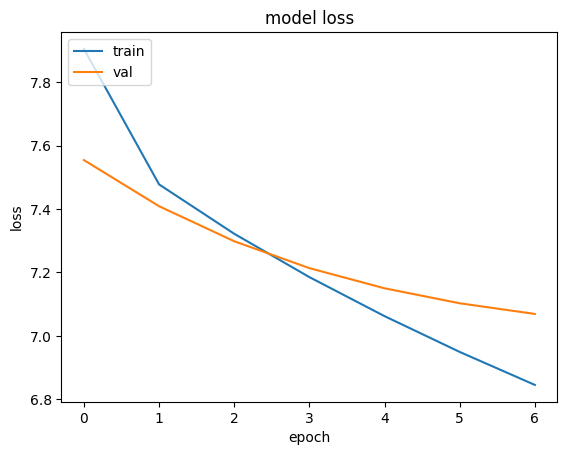

In [56]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Но нас интересует не сама задача классификации, а получившиеся векторные представления.

У нас есть два слоя с матрицами размера (длина словаря, 100). Можно взять векторные представления из любого из этих слоев или взять усредненный вектор.

In [57]:
model.layers

In [58]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(17017, 100)

In [59]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(100, 17017)

In [60]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T

In [61]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [62]:
embeddings.shape

(17017, 100)

In [63]:
most_similar('церковь', embeddings)

['церковь',
 'иисуса',
 'рига',
 'деревянная',
 'построенная',
 'собор',
 'башня',
 'павла',
 'церкви',
 'построена']

### CBOW


Теперь попробуем CBOW. В нем нужно по контексту предсказать целевое слово. В отличие от skip-gram тут сразу используется весь контекст, а векторы слов в контексте усредняются в 1 вектор контекста.

Собрать датасет очень просто.

In [64]:

X = []
y = []

window = 5
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]

        X.append(context)
        y.append(word)


Но нужно его немного поправить. В начале и конце текстов окна будут не полные и соответственно длина контекста будет не одинаковая. Но для преобразования в массив, длины должны быть одинаковыми. Решение этой проблемы - паддинг, добавление недостающего количества нулей  (может быть и другой индекс, но чаще всего именно 0).

In [65]:
# оригинальные контексты
X[:10]

[[7356, 8012, 8961, 2585],
 [7716, 8012, 8961, 2585, 8323],
 [7716, 7356, 8961, 2585, 8323, 16550],
 [7716, 7356, 8012, 2585, 8323, 16550, 734],
 [7716, 7356, 8012, 8961, 8323, 16550, 734, 8154],
 [7716, 7356, 8012, 8961, 2585, 16550, 734, 8154, 2585],
 [7356, 8012, 8961, 2585, 8323, 734, 8154, 2585, 12192],
 [8012, 8961, 2585, 8323, 16550, 8154, 2585, 12192, 11311],
 [8961, 2585, 8323, 16550, 734, 2585, 12192, 11311, 8961],
 [2585, 8323, 16550, 734, 8154, 12192, 11311, 8961, 13910]]

In [66]:
np.array(X[:10])

<ipython-input-66-9f065121fc4b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(X[:10])


array([list([7356, 8012, 8961, 2585]),
       list([7716, 8012, 8961, 2585, 8323]),
       list([7716, 7356, 8961, 2585, 8323, 16550]),
       list([7716, 7356, 8012, 2585, 8323, 16550, 734]),
       list([7716, 7356, 8012, 8961, 8323, 16550, 734, 8154]),
       list([7716, 7356, 8012, 8961, 2585, 16550, 734, 8154, 2585]),
       list([7356, 8012, 8961, 2585, 8323, 734, 8154, 2585, 12192]),
       list([8012, 8961, 2585, 8323, 16550, 8154, 2585, 12192, 11311]),
       list([8961, 2585, 8323, 16550, 734, 2585, 12192, 11311, 8961]),
       list([2585, 8323, 16550, 734, 8154, 12192, 11311, 8961, 13910])],
      dtype=object)

In [67]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [68]:
# контексты после паддинга
X

array([[7356, 8012, 8961, ...,    0,    0,    0],
       [7716, 8012, 8961, ...,    0,    0,    0],
       [7716, 7356, 8961, ...,    0,    0,    0],
       ...,
       [5921, 7115, 2585, ..., 9773,    0,    0],
       [7115, 2585, 2585, ...,    0,    0,    0],
       [2585, 2585, 6916, ...,    0,    0,    0]], dtype=int32)

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Сама модель почти полностью совпадает

In [70]:
model = tf.keras.Sequential()

# 1 отличие - то что на вход подается не 1 слово а целое окно контекста
# но на уровне embedding слоя нужно изменить только input_length
# она будет равна числу до которого мы делали паддинг
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=10,
                                    output_dim=100))

# 2 отличие - нужно усреднить контекст в 1 вектор
model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',

              )

In [71]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           1701700   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 17017)             1718717   
                                                                 
Total params: 3420417 (13.05 MB)
Trainable params: 3420417 (13.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [72]:

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
1729/1729 [==============================] - 57s 33ms/step - loss: 7.1635 - val_loss: 6.5502
Epoch 2/10
1729/1729 [==============================] - 23s 14ms/step - loss: 6.1990 - val_loss: 6.0845
Epoch 3/10
1729/1729 [==============================] - 22s 13ms/step - loss: 5.7556 - val_loss: 5.8810
Epoch 4/10
1729/1729 [==============================] - 22s 13ms/step - loss: 5.4692 - val_loss: 5.7733
Epoch 5/10
1729/1729 [==============================] - 23s 13ms/step - loss: 5.2545 - val_loss: 5.7175
Epoch 6/10
1729/1729 [==============================] - 22s 13ms/step - loss: 5.0830 - val_loss: 5.6958
Epoch 7/10
1729/1729 [==============================] - 21s 12ms/step - loss: 4.9425 - val_loss: 5.6907
Epoch 8/10
1729/1729 [==============================] - 22s 13ms/step - loss: 4.8246 - val_loss: 5.7028
Epoch 9/10
1729/1729 [==============================] - 21s 12ms/step - loss: 4.7247 - val_loss: 5.7241
Epoch 10/10
1729/1729 [==============================] - 21s 12m

In [73]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [74]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [75]:
embeddings.shape

(17017, 100)

In [76]:
most_similar('птица', embeddings)

['птица',
 'блестящий',
 'птицы',
 'семейства',
 'распространена',
 'голова',
 'красная',
 'зелёной',
 'смешанные',
 'подсемейства']

In [77]:
most_similar('гнездо', embeddings)

['гнездо',
 'самка',
 'самец',
 'деревьях',
 'яиц',
 'яйца',
 'строит',
 'цветения',
 'хозяина',
 'змей']

In [78]:
most_similar('роза', embeddings)

['роза',
 'врач',
 'доктор',
 'адвокат',
 'рой',
 'друзья',
 'даниэль',
 'яковлевич',
 'майк',
 'возвращаются']

### Negative sampling

Одна из основных оптимизаций в word2vec - negative sampling. Задача из многоклассовой классификации преобразуется в бинарную классификацию. На вход подается сразу и целевое слово и контекст, а на выходе ожидается вероятность того, что они употребляются вместе. Положительные примеры просто берутся из корпуса, а для того, чтобы собрать негативные примеры, из словаря просто случайно выбираются слова. Возможна ситуация, когда для контекста случайно выбранное слово на самом деле может встретиться в этом контексте, но за счет большого количества примеров, такие неточности не повлияют на итоговый результат.

В этот раз не будем сразу генерировать весь датасет. Он получается очень большой и эффективнее генерировать примеры на ходу (т.е. использовать генератор)

In [79]:
vocab_size = len(id2word)

Эта функция просто генерирует обучающее примеры батчами. В tf генераторы можно напрямую модавать в fit модели

In [80]:
# skip gram
def gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [81]:
# # cbow
def gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

Саму модель нужно уже задать через Functional API, т.к. у нас будет два входа

In [82]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [83]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 92s 9ms/step - loss: 0.4738 - accuracy: 0.7793 - val_loss: 0.5300 - val_accuracy: 0.7610
Epoch 2/2
10000/10000 [==============================] - 77s 8ms/step - loss: 0.4502 - accuracy: 0.7971 - val_loss: 0.4810 - val_accuracy: 0.7809


In [84]:
embeddings = model.layers[2].get_weights()[0]

In [85]:
most_similar('знания', embeddings)

['знания',
 'семейных',
 'соединены',
 'вероятность',
 'ошибок',
 'подразумевает',
 'по-разному',
 'свойств',
 'шины',
 'имеющие']

In [86]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [87]:
model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 139s 28ms/step - loss: 0.3750 - accuracy: 0.8336 - val_loss: 0.2962 - val_accuracy: 0.8763
Epoch 2/2
5000/5000 [==============================] - 65s 13ms/step - loss: 0.2656 - accuracy: 0.8892 - val_loss: 0.2535 - val_accuracy: 0.8967


In [88]:
embeddings = model.layers[2].get_weights()[0]

In [89]:
most_similar('семья', embeddings)

['семья',
 'жила',
 'родители',
 'бабушка',
 'замке',
 'проживала',
 'переехать',
 'перевели',
 'матери',
 'переехала']

In [90]:
most_similar('церковь', embeddings)

['церковь',
 'церкви',
 'часовня',
 'монастыря',
 'православная',
 'храм',
 'святого',
 'монастырь',
 'храма',
 'святому']

Другая значимая оптимизация в word2vec - это иерархический софтмакс. Когда мы считали модель без негативного семплирования, то у нас был большой полносвязный слой с софтмаксом. Иерархический софтмакс упрощает расчеты в этом слое, но его уже так просто не воспроизведешь.

На этом месте уже лучше перейти к готовой реализации.

## Word2Vec в gensim

В gensim есть питоновская обертка к оригинальному ворд2веку, которой очень удобно пользоваться.

In [91]:
# !pip install gensim

In [92]:
import gensim

In [93]:
#?gensim.models.Word2Vec

In [94]:
gensim.__version__

'4.3.2'

На вход нужно подавать список списков (токенизированный текст)

In [97]:
wiki = open('/content/wiki_data.txt').read().split('\n')

In [98]:
texts = [preprocess(text) for text in wiki]

In [99]:
# f = open('corpus.txt', 'w')
# for text in texts:
#     f.write(' '.join(text) + '\n')
# f.close()

In [100]:
# corpus = gensim.models.word2vec.LineSentence('corpus.txt', )

В саму модель нужно передать корпус для обучения, для остальных параметров есть значения по умолчанию

In [101]:
%%time
w2v = gensim.models.Word2Vec(texts, )

CPU times: user 1min 5s, sys: 269 ms, total: 1min 5s
Wall time: 39.7 s


In [102]:
w2v.wv.most_similar('обучение')

[('университете', 0.8261229395866394),
 ('московском', 0.8171250820159912),
 ('академию', 0.7993197441101074),
 ('гимназии', 0.7854116559028625),
 ('курс', 0.7853259444236755),
 ('учёбу', 0.7822868227958679),
 ('колледже', 0.7820054888725281),
 ('школу', 0.7781623005867004),
 ('училище', 0.7775765657424927),
 ('институте', 0.7722584009170532)]

Давайте теперь разберемся с параметрами:

**vector_size** - размер вектора, обычно используют значение 100-1000  

**min_count** - минимальная частота слова в корпусе (выше мы тоже фильтровали по частототе 30)  

**max_vocab_size** - максимальный размер словаря

**window** - размер окна (выше мы использовали значение 10)

**epochs** - количество эпох (полных итераций по корпусу)

In [103]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=30,
                             max_vocab_size=10000,
                             window=5,
                             epochs=7)

CPU times: user 45.6 s, sys: 348 ms, total: 46 s
Wall time: 28.9 s


In [104]:
w2v.wv.most_similar('университет')

[('институт', 0.7640633583068848),
 ('искусств', 0.7169204354286194),
 ('университета', 0.713912308216095),
 ('университете', 0.7114648818969727),
 ('государственный', 0.6101142764091492),
 ('окончил', 0.6061140298843384),
 ('курс', 0.5888267159461975),
 ('музей', 0.5847302675247192),
 ('школе', 0.5784987211227417),
 ('школу', 0.5580280423164368)]

CBOW или Skip-gram выбираются через параметр **sg** - 1 это skip-gram, а 0 - cbow (по умолчанию всегда cbow)

In [105]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=30,
                             max_vocab_size=10000,
                             window=5,
                             epochs=7,
                             sg=1
                            )

CPU times: user 2min 28s, sys: 355 ms, total: 2min 29s
Wall time: 1min 31s


Скип-грам обучается значительно дольше

In [106]:
w2v.wv.most_similar('церковь')

[('храм', 0.6445897221565247),
 ('храма', 0.5493179559707642),
 ('собор', 0.5315577983856201),
 ('церкви', 0.5217152833938599),
 ('монастыря', 0.5025280117988586),
 ('монастырь', 0.4901488423347473),
 ('епархии', 0.46983271837234497),
 ('школа', 0.4583413600921631),
 ('собора', 0.43036291003227234),
 ('здание', 0.4241810739040375)]

Увеличения window на cbow практически не влияет

In [107]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=30,
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,

                            )

CPU times: user 54.1 s, sys: 343 ms, total: 54.5 s
Wall time: 33.7 s


А вот skip-gram сильно замедляется с увеличением окна

In [108]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=30,
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,
                             sg=1
                            )

CPU times: user 4min 20s, sys: 485 ms, total: 4min 21s
Wall time: 2min 39s


In [109]:
w2v.wv.most_similar('церковь')

[('храм', 0.677635908126831),
 ('церкви', 0.6033709645271301),
 ('храма', 0.6031384468078613),
 ('собор', 0.5255852937698364),
 ('здание', 0.4903264045715332),
 ('монастырь', 0.4889829754829407),
 ('монастыря', 0.4825196862220764),
 ('собора', 0.4430254101753235),
 ('епархии', 0.44184255599975586),
 ('школа', 0.4299960732460022)]

Есть еще несколько параметров, но уже не таких влиятельных:

1) **sample** - отвечает за downsampling частотных слов; чем меньше, тем сильнее штрафуются частотные слова (по умолчанию стоит 1e-3, но можно поставить 1e-4, 1e-5). Для sg это будет значительно влиять на скорость (1e-5 будет быстрее)  
2) **ns_exponent** -  регулирет downsampling частотных слов в negative sampling; 0 - никакого штрафа за частотность (как у нас выше с полным рандомом), 1 - штрафует пропорционально частотности, значения 0-1 что-то посередине (по умолчанию стоит 0.75)  
3) **cbow_mean** - отвечает за функцию агрегации в cbow; 1 - это среднее, 0 - сумма (у нас выше среднее, оно же стоит по умолчанию)  

In [110]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             sample=1e-5,
                             sg=1
                            )

CPU times: user 2min 27s, sys: 487 ms, total: 2min 28s
Wall time: 1min 28s


In [111]:
w2v.wv.most_similar('церковь')

[('часовня', 0.9664997458457947),
 ('храм', 0.9561964869499207),
 ('деревянная', 0.9532985091209412),
 ('храма', 0.9509243965148926),
 ('собор', 0.9446122646331787),
 ('монастыря', 0.9437782764434814),
 ('чудотворца', 0.9429551959037781),
 ('богородицы', 0.9396995902061462),
 ('часовни', 0.9385166764259338),
 ('божией', 0.9348099231719971)]

In [112]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             ns_exponent=0.84
                            )

CPU times: user 1min 6s, sys: 457 ms, total: 1min 6s
Wall time: 41 s


In [113]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8448782563209534),
 ('деревянная', 0.8317247033119202),
 ('православная', 0.8108007311820984),
 ('построена', 0.8088724613189697),
 ('построенная', 0.8005377650260925),
 ('храм', 0.7902143001556396),
 ('каменная', 0.781539797782898),
 ('богородицы', 0.7746227383613586),
 ('монастыря', 0.7705715894699097),
 ('монастыре', 0.7633407711982727)]

In [114]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             cbow_mean=0
                            )

CPU times: user 1min 5s, sys: 459 ms, total: 1min 6s
Wall time: 39.4 s


In [115]:
w2v.wv.most_similar('церковь')

[('каменная', 0.9372625350952148),
 ('деревянная', 0.9247540831565857),
 ('богородицы', 0.9223313927650452),
 ('икона', 0.9181458353996277),
 ('пресвятой', 0.9083084464073181),
 ('святителя', 0.9062252640724182),
 ('построена', 0.9050227999687195),
 ('собор', 0.9010735750198364),
 ('храм', 0.9007969498634338),
 ('покрова', 0.9003905653953552)]

## FastText

В 2015 почти та же команда выпустила улучшение - FastText (статья - https://arxiv.org/abs/1607.04606). Главная доработка в нем - использование символьных нграммов. В оригинальном word2vec словарь обучается вначале и фиксируется, добавлять новые слова к обученной модели нельзя. Соответственно, если слова нет в словаре, то и вектора для него не будет.

В FastText каждое слово дополнительно разбивается на символьные нграммы и для каждого символьного нграмма тоже есть свой отдельный эмбеддинг. При предсказании векторы символьных нграммов и целого слова усредняются в 1 вектор. В дальнейшем это позволяет генерировать векторы для слов, которых нет в изначальном словаре. Нужно только чтобы новое слово состояло уже из известных символьных нграмм.

Интерфейс обучения и большинство параметров - точно такие же

In [118]:
%%time
ft = gensim.models.FastText(texts)

CPU times: user 5min 38s, sys: 825 ms, total: 5min 38s
Wall time: 3min 33s


Использование символьных нграммов сразу заметно - близким считаются слова похожие по написанию, а не только по смыслу

In [117]:
ft.wv.most_similar('церковь')

NameError: ignored

Дополнительные параметры:

1) **min_n** - минимальная длина для символьных нграмм (по умолчанию 3)  
2) **max_n** - максимальная длина для символьных нграмм, если поставить меньше min_n, то символьные нграммы не будут использоваться (по умолчанию 6)

In [ ]:
%%time
ft = gensim.models.FastText(texts, min_n=2, max_n=8)

In [ ]:
ft.wv.most_similar('церковь')

### Использование предобученных моделей

В открытом доступе есть много предобученных моделей. Они как правило обучены на неспецифических, но очень больших корпусах (новостных, википедии). Если в решаемой задаче тексты похожи, то лучше использовать предобученные модели. Свои модели имеет смысл обучать, когда данные очень специфичные.

Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/

Нужно скачать какую-то модель, распаковать и открыть в генсиме.
